<center><h2>Predicting If a Person Likes a Dog or a Cat</h2></center>
Uses: Machine Learning, Random Forest Classifier

In [70]:
#Import all the necessary Libraries

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn

#Use a magic command to display the graphs better
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# Set the random seed to have reproducible results
np.random.seed(42)

# These two includes help us render a graph
from subprocess import call
from IPython.display import Image

In [71]:
# Import the data into a Pandas DataFrame
df = pd.read_csv("cat-and-dog.csv")

In [72]:
# Let's see the first few rows of data
df.head(5)

,walking,running,color,distance_walked,dogs_cats
0,1,1,red,1,1
1,1,1,blue,2,1
2,1,1,green,3,1
3,1,1,blue,4,1
4,1,1,blue,5,1


In [73]:
# Check the data types
df.dtypes

walking             int64
running             int64
color              object
distance_walked     int64
dogs_cats           int64
dtype: object

Data preparation: let's change the names of some of the columns, including marking ```dogs_cats``` as an out label.

In [74]:
df.columns = ['walk', 'run', 'color', 'distance', 'label']

Let's look at the statistical distribution of the data

In [75]:
df.describe()

,walk,run,distance,label
count,199.000000,199.000000,199.000000,199.000000
mean,0.497487,0.497487,4.979899,0.321608
std,0.501255,0.501255,2.597512,0.468272
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,5.000000,0.000000
75%,1.000000,1.000000,7.000000,1.000000
max,1.000000,1.000000,9.000000,1.000000


For model to understand the data format, it needs to be catagorized in the proper format.

Despite the `walk`, `run`, and `label` columns being integers, they are actually representing a binary value, 1 or 0. For `walk` and `run`, this corresponds to True or False for liking that activity. For `label`, this represents whether you prefer cats or dogs. Instead of using integers, let's change these fields to the boolean data type.

`color_type` is not random text. It actually represents one of three categories (red, green, or blue). Instead of treating it as text, let's change it to a categorical data type.

The distance will be left as a number.

In [76]:
# Set the Data types for each of our columns

df['walk'] = df['walk'].astype('bool')
df['run'] = df['run'].astype('bool')
color_type = CategoricalDtype(categories=['red','green','blue'])
df['color'] = df['color'].astype(color_type)
df['label'] = df['label'].astype('bool')

In [77]:
df.dtypes

walk            bool
run             bool
color       category
distance       int64
label           bool
dtype: object

`color` is a list of strings, therefore, use the `get_dummies` command to perform a one hot encoding process directly into the dataframe.

In [78]:
# Perform one-hot encoding of our `colors` column
df = pd.get_dummies(df, prefix=['color'])

With data formatting complete, let's take a quick look at what our data looks like now.

In [79]:
df.head(10)

,walk,run,distance,label,color_red,color_green,color_blue
0,True,True,1,True,True,False,False
1,True,True,2,True,False,False,True
2,True,True,3,True,False,True,False
3,True,True,4,True,False,False,True
4,True,True,5,True,False,False,True
5,True,True,6,True,True,False,False
6,True,True,7,True,False,True,False
7,True,True,8,True,False,True,False
8,True,True,9,True,False,False,True
9,True,True,1,True,True,False,False


<a id='section3'></a>

Lastly, split the data into training and testing sets. We use scikit-learn's `train_test_split` to split off 20% of the data for testing so we have 80% for training. We also set `random_state` so that we'll have a random, but repeatable, data split.

In [83]:
# Split the dataset into 80% Training, and 20% Testing

X_train, X_test, y_train, y_test = train_test_split(df.drop(labels='label', axis=1), df['label'], test_size = .2, random_state = 10)


Now, let's create a `RandomForestClassifier` moodel. We set one parameter, but there are many more options for tweaking the model.

In [85]:
model = RandomForestClassifier(max_depth=5)

In [86]:
# Fit the model to use our training data
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [23]:
# Grab the estimator from the trained model

estimator = model.estimators_[0]
feature_names = [i for i in X_train.columns]

Let's get a graphical representation of __one of__ the trees in our forest. __After this code block has run, wait a moment for the graph to appear.__

In [24]:
export_graphviz(estimator, out_file='tree.dot',
                feature_names = feature_names,
                rounded = True,
                filled = True)

# Use CLI Graphviz to create a png file from our graph data:
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

Image(filename = 'tree.png')

In [88]:
# Use the Testing dataset to produce the first predictions

y_predict = model.predict(X_test)

To see how it performed, let's use ```confusion_matrix``` to create a confusion matrix for the test data predictions.

In [89]:
conf_matrix = confusion_matrix(y_test, y_predict)
conf_matrix

array([[23,  3],
       [11,  3]])

Let's better visualize it using the `seaborn` library.

tn: true negative \
fp: false positive \
fn: false negative\
tp: true positive

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Actual', ylabel='Predicted'>

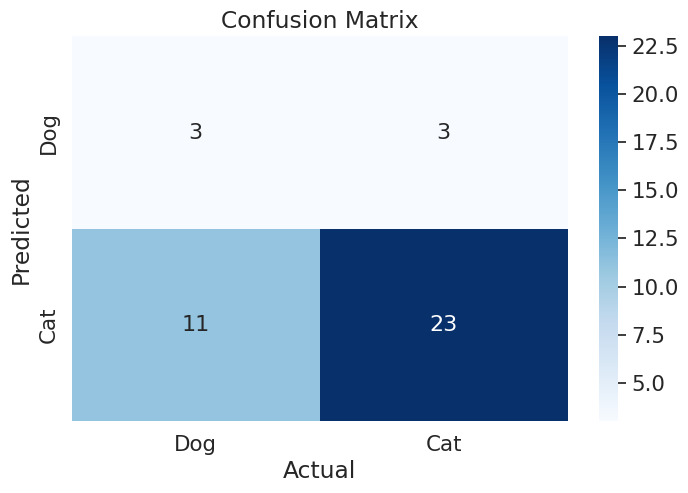

In [91]:
tn, fp, fn, tp = conf_matrix.ravel()
cleaned_conf_matrix = np.array([[tp, fp], [fn, tn]])
y_true = ["Dog", "Cat"]
df_cm = pd.DataFrame(cleaned_conf_matrix, columns=y_true, index=y_true)
df_cm.index.name = 'Predicted'
df_cm.columns.name = 'Actual'

df_cm.dtypes

plt.figure(figsize = (8,5))
plt.title('Confusion Matrix')
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

In [93]:
# Using the matrix, let's calculate sensitivity and specificity.
sensitivity = tp / (tp + fn)
print('Sensitivity : ', sensitivity )

specificity = tn / (tn + fp)
print('Specificity : ', specificity)

Sensitivity :  0.21428571428571427
Specificity :  0.8846153846153846


Let's visulaize through ROC Graph (receiver operating characteristic)

A ROC curve, is a graphical plot that illustrates the performance of a binary classifier model at varying threshold values. The ROC curve is the plot of the true positive rate against the false positive rate at each threshold setting.

fpr: false positive rate \
tpr: true positive rate \

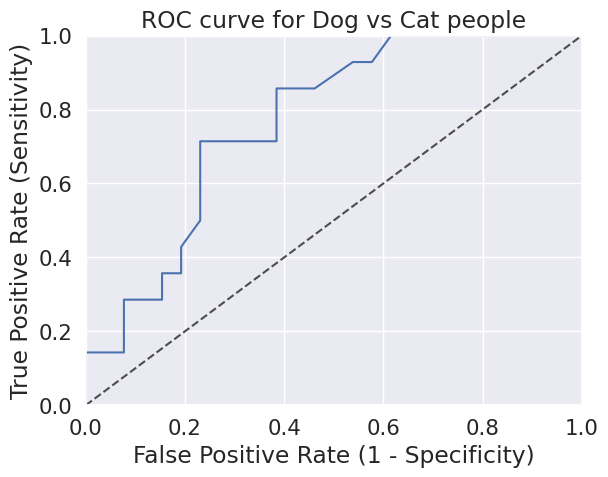

In [29]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Dog vs Cat people')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

What is the Area Under the Curve (AUC)?

In [94]:
auc(fpr, tpr)

0.7664835164835165

Change the values for the survey questions below and see what the model predicts for you!

* `walk`/`run` should be set to either `0` for no, or `1` for yes
* `distance` should be set to a `float` number
* The `color` should be set to `1` for your favorite, and `0` for the rest

In [95]:
data = pd.DataFrame([{
    'walk': 1,
    'run': 1,
    'distance': 10,
    'color_red': 0,
    'color_green': 0,
    'color_blue': 1
}])

prediction = model.predict(data)
print(prediction)

[ True]


`True` is equivalent to dog-person. `False` is equivalent to cat-person.